In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
data = pd.read_csv('DBtrainrides.csv', encoding='UTF-8')

Cleaning path column

In [3]:
def clean_station_name(station: str) -> str:
    """Clean one station name: remove hyphens, brackets, and trim spaces."""
    station = station.replace('-', ' ')       # replace hyphens with spaces
    station = station.replace('(', ' ')    # replace brackets with spaces
    station = station.replace(')', ' ')    # replace brackets with spaces
    station = station.replace('Hauptbahnhof', 'Hbf')
    station = re.sub(r'\s+', ' ', station)
    return station.strip()

def clean_path(path: str) -> str:
    """Clean a full path, applying cleaning per station."""
    if not isinstance(path, str) or not path.strip():
        return ''
    stations = path.split('|')
    cleaned = [clean_station_name(s) for s in stations]
    return '|'.join(cleaned)

# Apply cleaning
data['path'] = data['path'].apply(clean_path)

Cleaning station column

In [4]:
data['station'] = data['station'].apply(clean_station_name)

Line types distribution before corrections

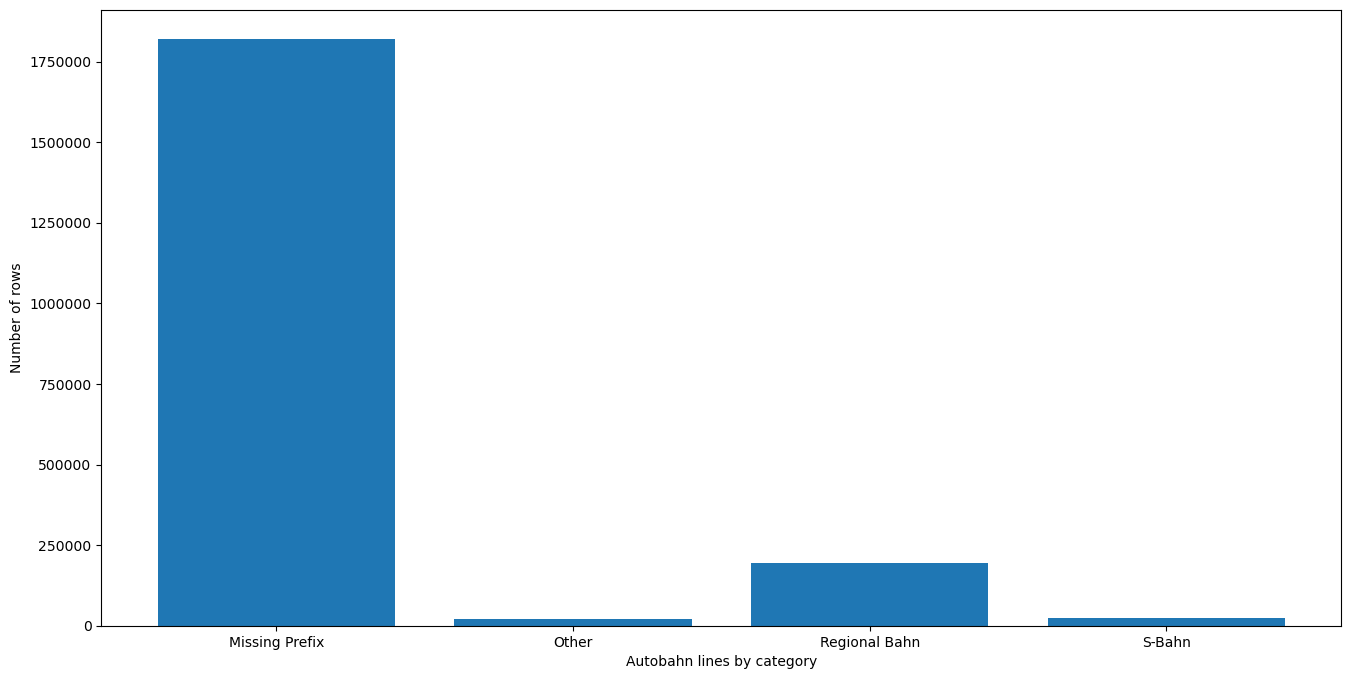

In [5]:
lines = data['line'].dropna().astype(str)
def classify_line(line):
    if pd.isna(line):
        return None
    line = str(line).upper().strip()

    if re.match(r'^(ICE|IC|EC)', line):
        return 'Long Distance'
    elif re.match(r'^(RE|IRE|RB|RS|C)', line):
        return 'Regional Bahn'
    elif re.match(r'^S', line):
        return 'S-Bahn'
    elif re.match(r'^\d+[A-Z]?$' , line):  # e.g. 10, 10B, 25A
        return 'Missing Prefix'
    else:
        return 'Other'

counts =lines.apply(classify_line).value_counts().sort_index()

plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
plt.bar(counts.index, counts.values)
plt.xlabel("Autobahn lines by category")
plt.ylabel("Number of rows")
plt.show()

Adding the correct prefix to line

In [6]:
mapping = pd.read_csv("lines/correct_line_mapping.csv")

In [7]:
def get_fixed_line(row):
    matches = mapping[
        mapping['full_path'].str.contains(row['path'], na=False, regex=False) &
        (mapping['line'] == row['line'])
    ]['fixed_line'].unique()

    # Return first match if any
    return matches[0] if len(matches) > 0 else row['line']

data['line'] = data.apply(get_fixed_line, axis=1)

Line types distribution after corrections

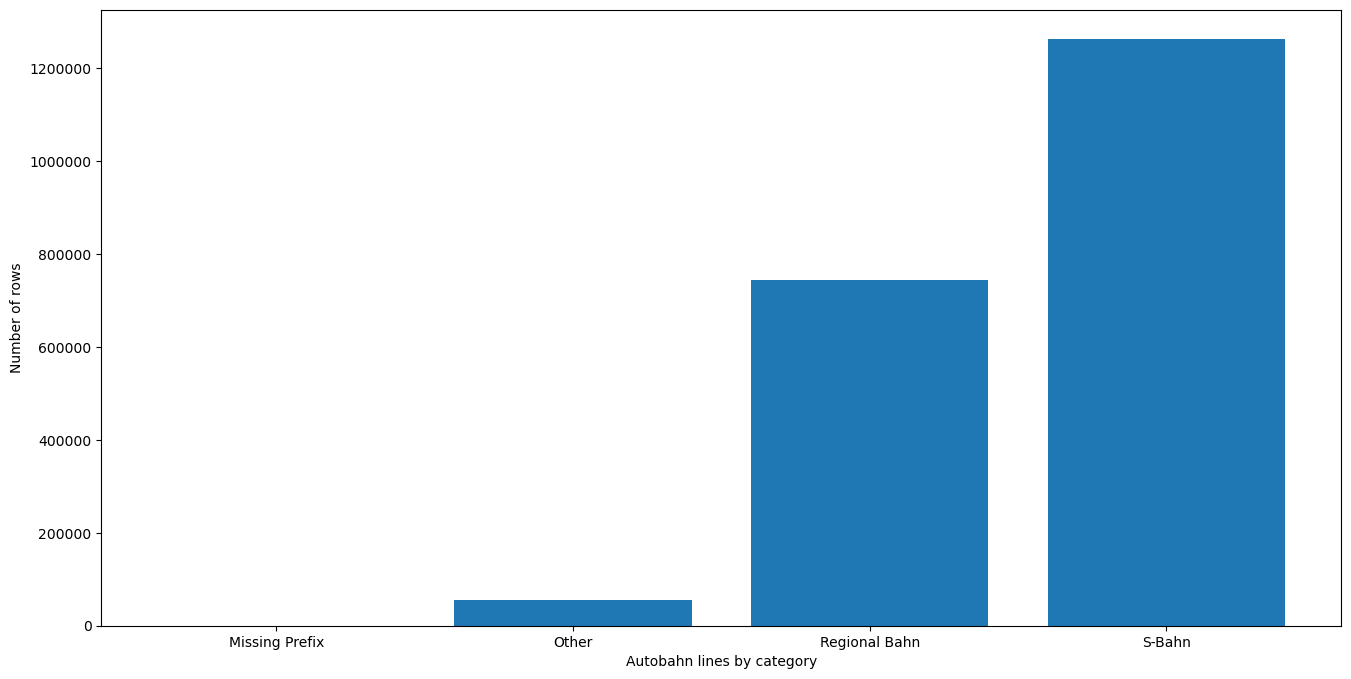

In [8]:
lines = data['line'].dropna().astype(str)
def classify_line(line):
    if pd.isna(line):
        return None
    line = str(line).upper().strip()

    if re.match(r'^(RE|IRE|RB|RS|C)', line):
        return 'Regional Bahn'
    elif re.match(r'^S', line):
        return 'S-Bahn'
    elif re.match(r'^\d+[A-Z]?$' , line):  # e.g. 10, 10B, 25A
        return 'Missing Prefix'
    else:
        return 'Other'

classified = lines.apply(classify_line)
counts = classified.value_counts().sort_index()

plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
plt.bar(counts.index, counts.values)
plt.xlabel("Autobahn lines by category")
plt.ylabel("Number of rows")
plt.show()

Checking what values are classified as other

In [9]:
unknown_lines = lines[classified == 'Other'].unique()
print(unknown_lines)

['EV' 'MEX17A' 'MEX13' '3S3' 'N3' 'EV22A' 'EM24' 'FLX30' 'MEX16' 'A3'
 'MEX12' 'U28' 'RT1' 'L7' 'RJX62' 'A2' 'MEX19' 'FLX35' 'FLX20' 'MEX18'
 'RNV3' 'Biker' 'N14' 'MEX' 'X85F' 'T9' 'FEX' 'WX' 'EX']


Dropping rows with line 'Biker'

In [10]:
data = data[data['line'] != 'Biker']

The 'other' line distribution

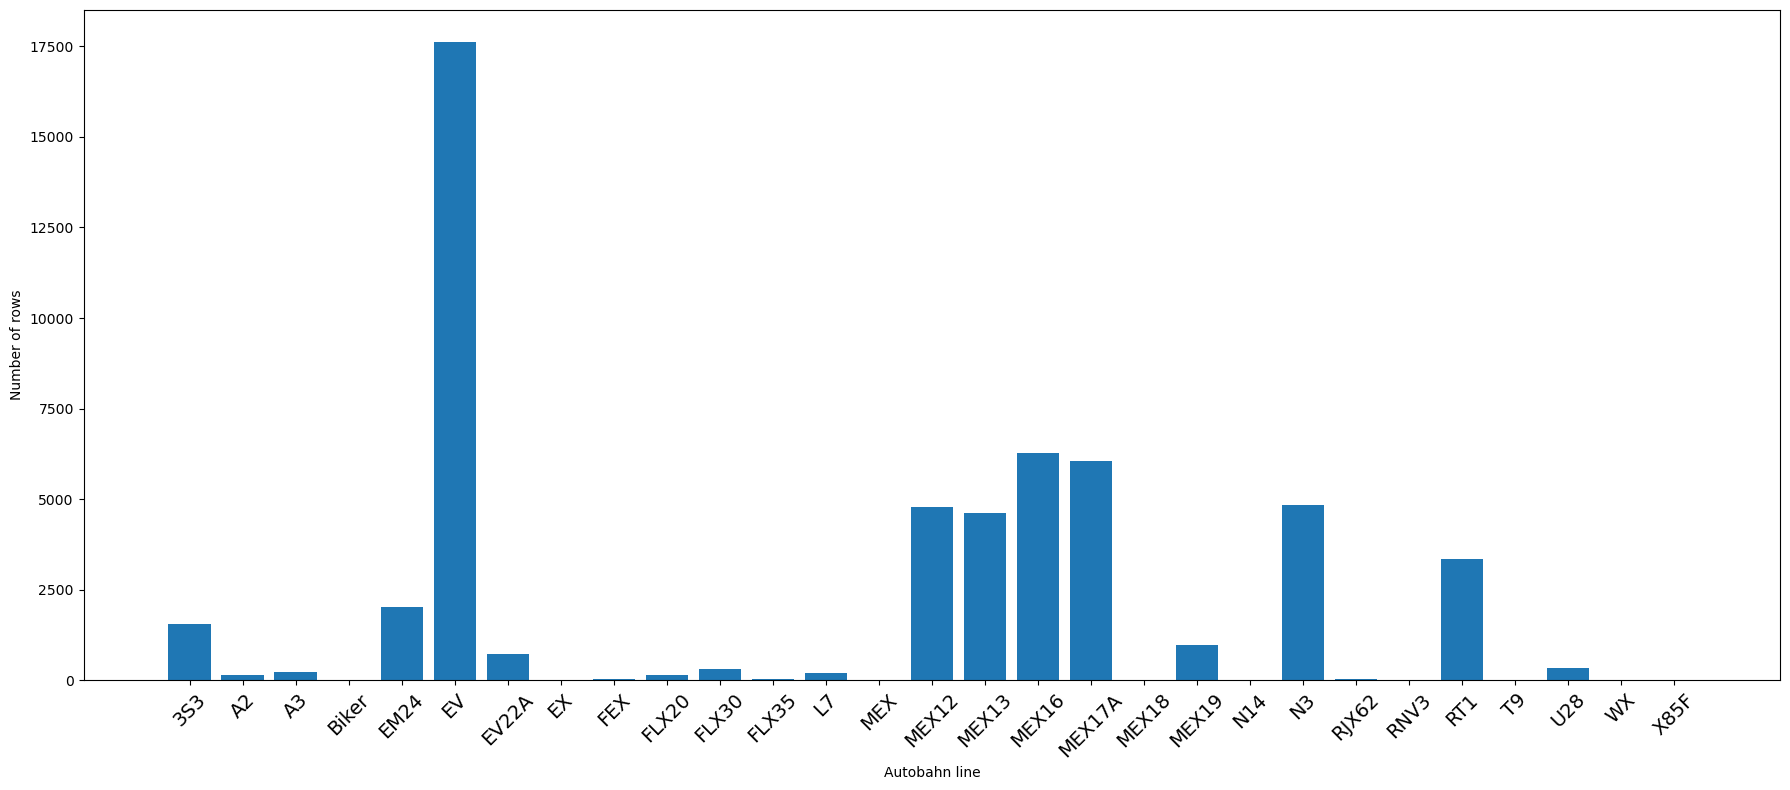

In [11]:
counts = lines[classified == 'Other'].value_counts().sort_index()
plt.figure(figsize=(18,8))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=14)
plt.xlim(-2, len(counts.index) + 1) 
plt.tight_layout()
plt.show()

Regional line RE

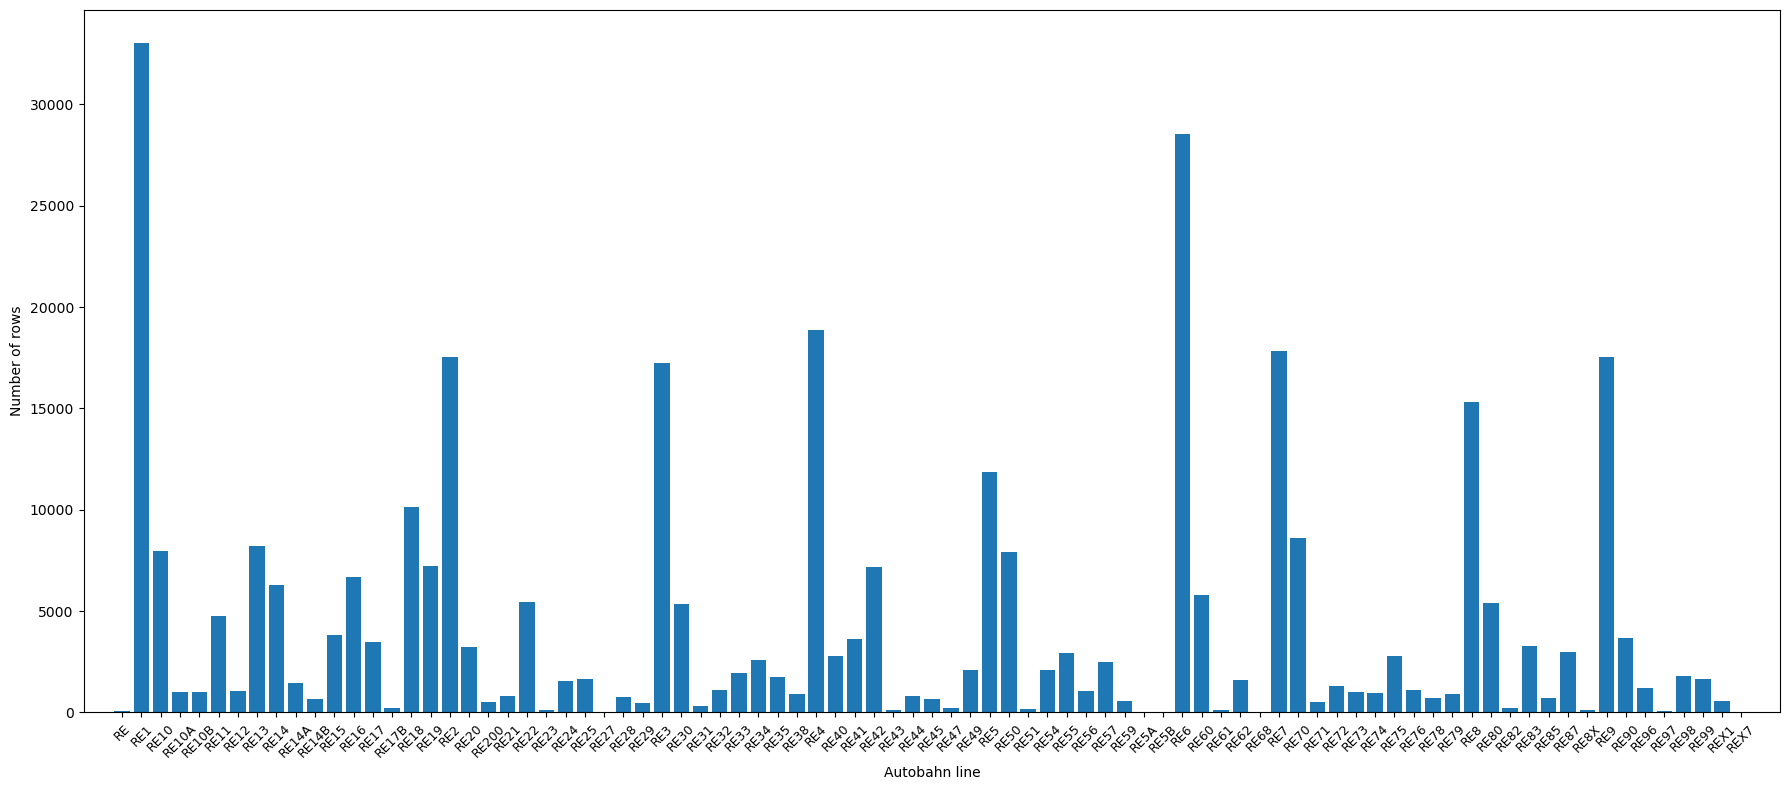

In [12]:
regional = lines[classified == 'Regional Bahn']
regional_re = regional[regional.str.startswith('RE')].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_re.index.astype(str), regional_re.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=9)
plt.xlim(-2, len(regional_re.index) + 1) 
plt.tight_layout()
plt.show()

Regional line RB

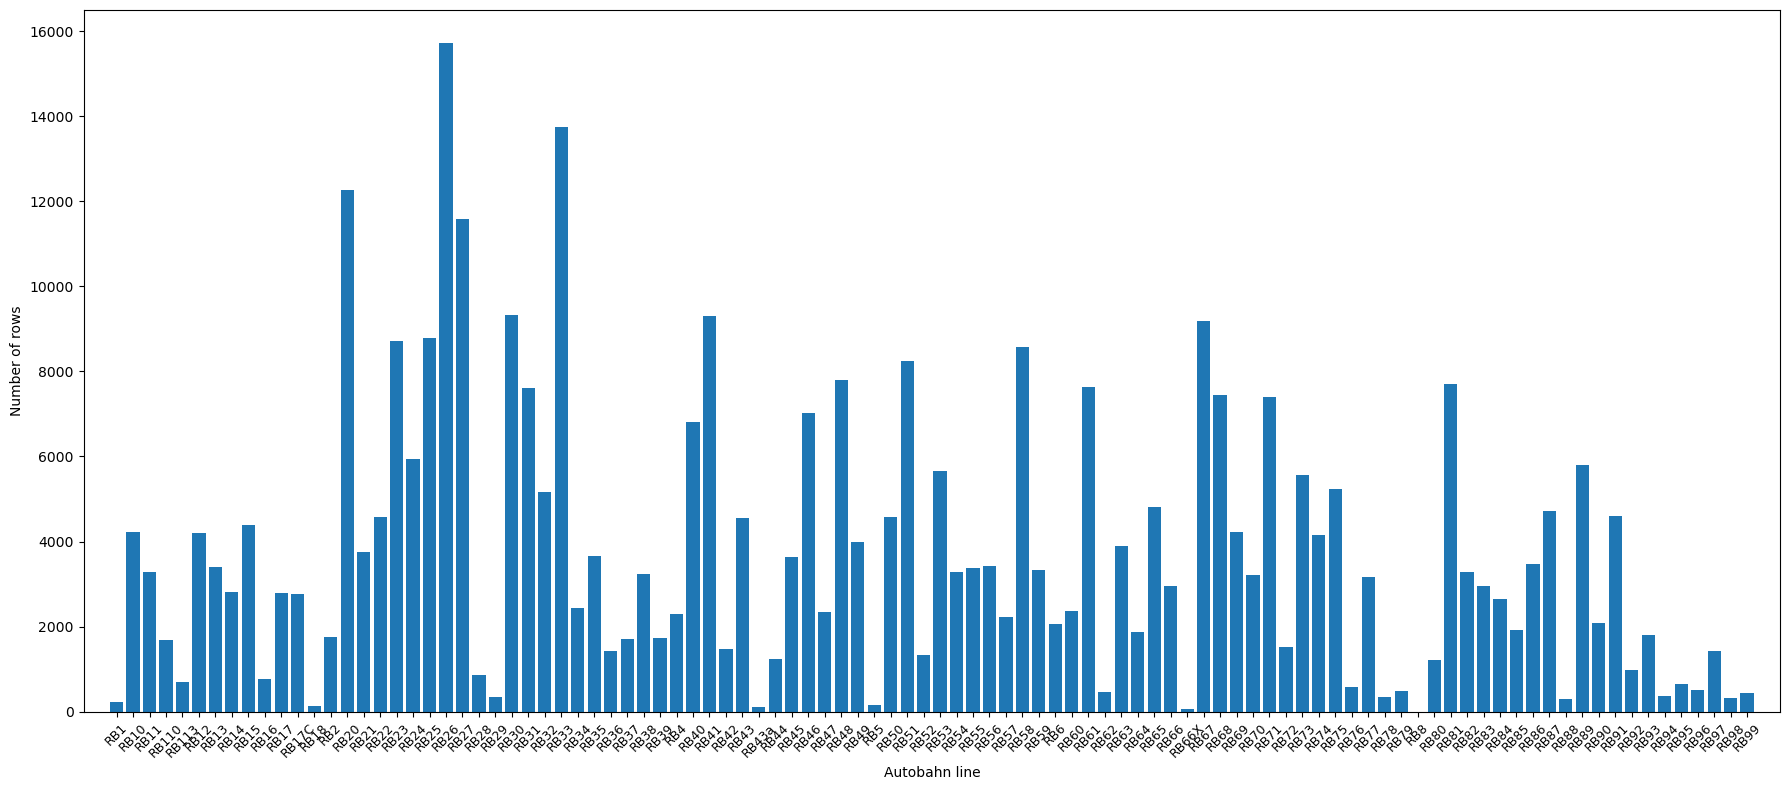

In [13]:
regional_rb = regional[regional.str.startswith('RB')].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_rb.index.astype(str), regional_rb.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=9)
plt.xlim(-2, len(regional_rb.index) + 1) 
plt.tight_layout()
plt.show()

Regional lines RS and C

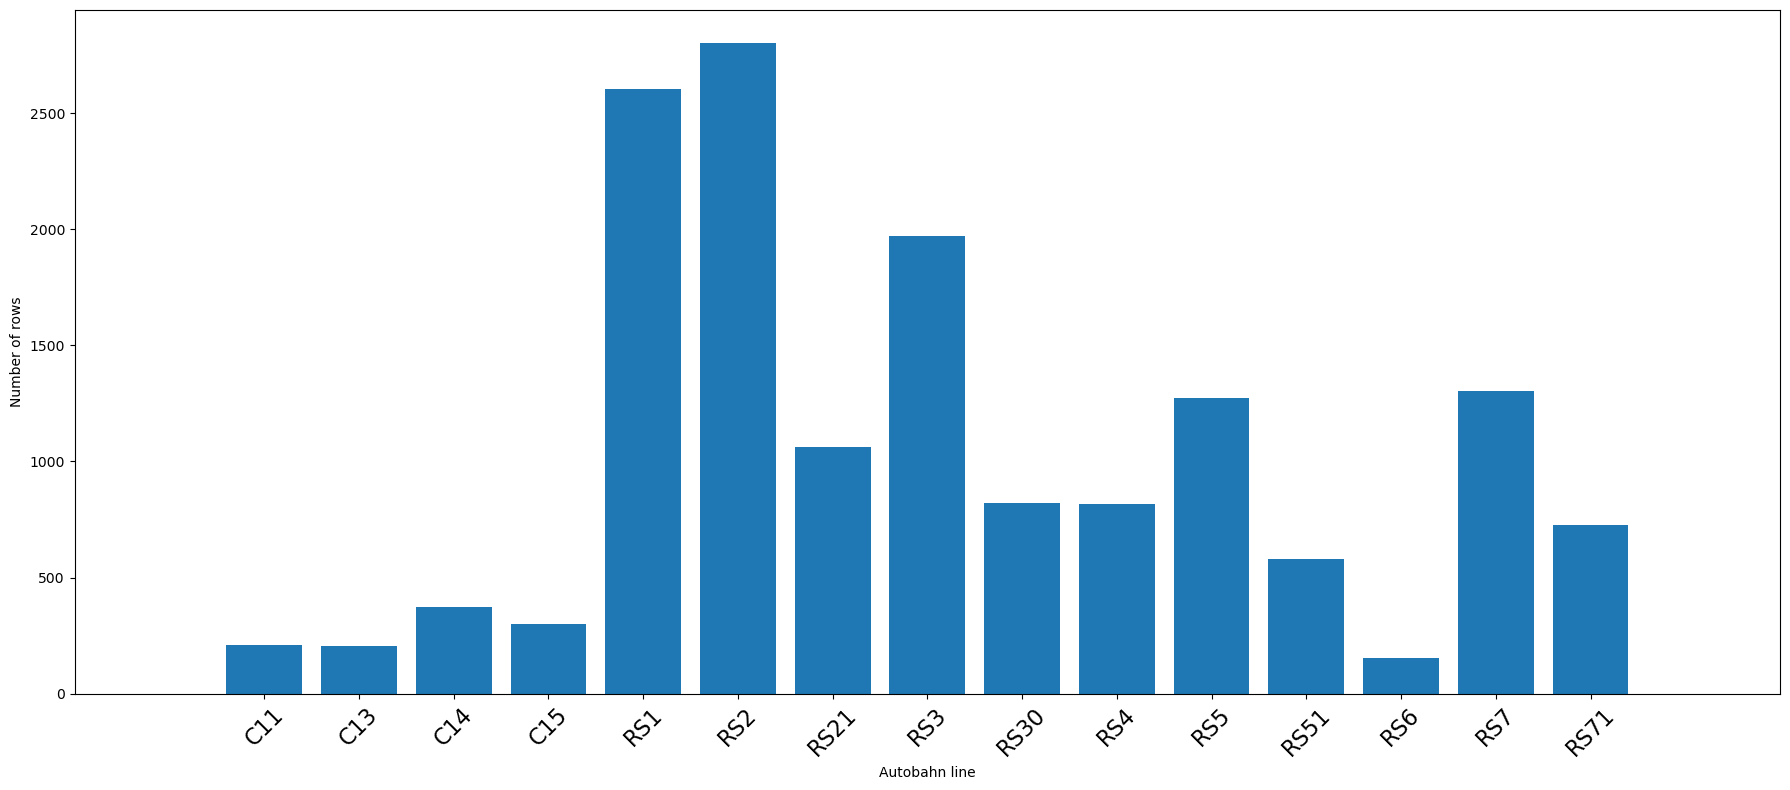

In [14]:
regional_rs_c = regional[regional.str.startswith(('RS', 'C'))].value_counts().sort_index()

plt.figure(figsize=(18,8))
plt.bar(regional_rs_c.index.astype(str), regional_rs_c.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=16)
plt.xlim(-2, len(regional_rs_c.index) + 1) 
plt.tight_layout()
plt.show()

S-Bahn lines

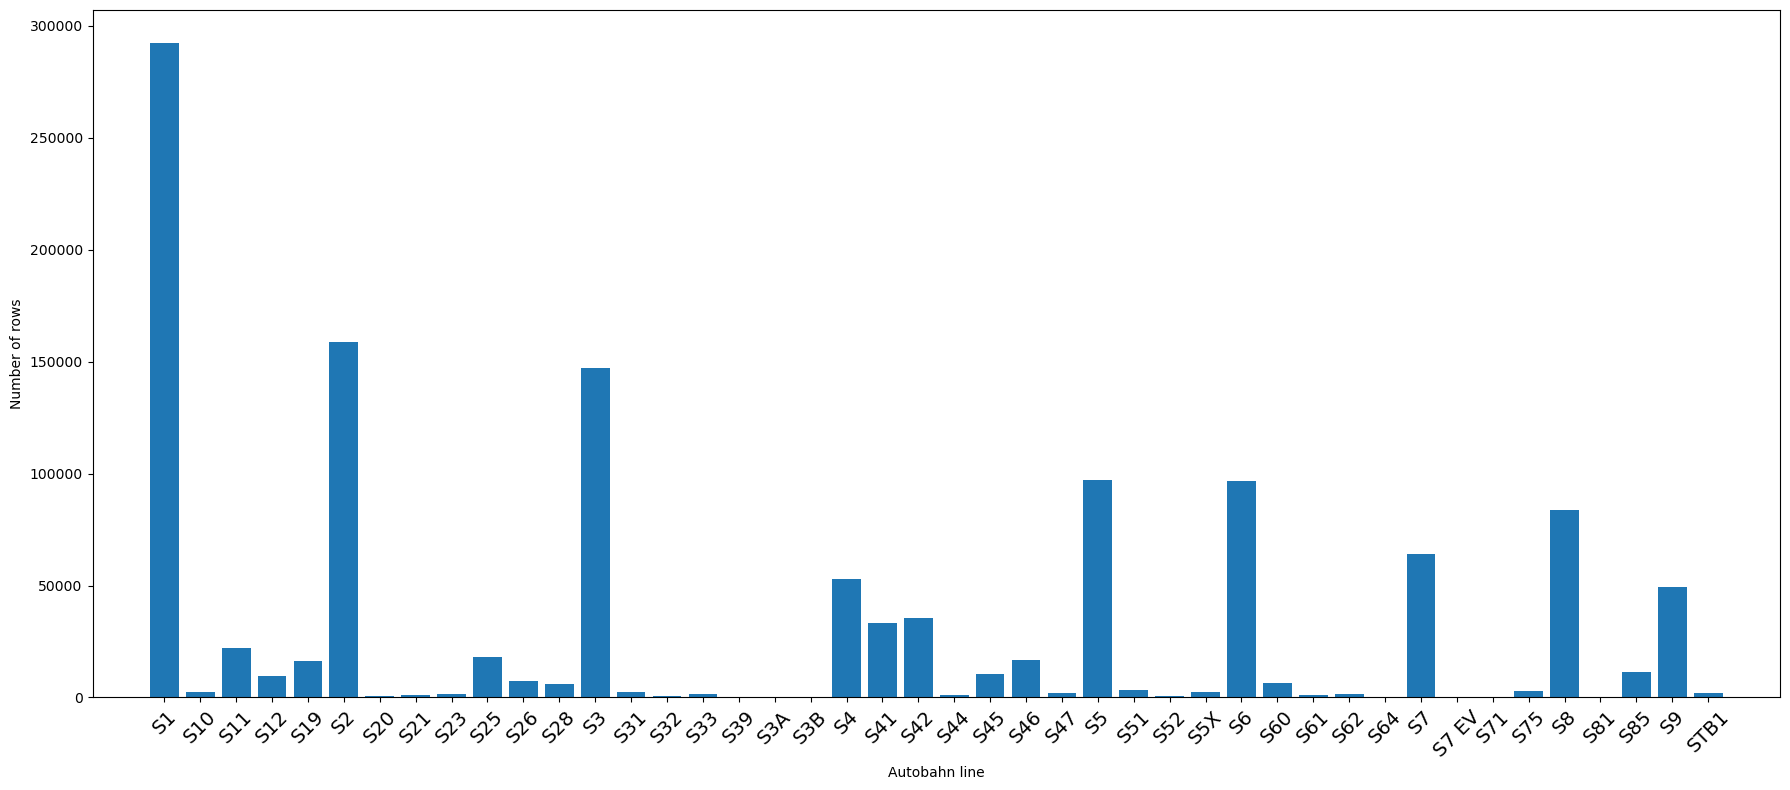

In [15]:
counts = lines[classified == 'S-Bahn'].value_counts().sort_index()
plt.figure(figsize=(18,8))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Autobahn line")
plt.ylabel("Number of rows")
plt.xticks(rotation=45,fontsize=14)
plt.xlim(-2, len(counts.index) + 1) 
plt.tight_layout()
plt.show()

## Generating train line file

In [16]:
data['ID_fixed'] = data['ID'].astype(str).str.replace(r"^-", "", regex=True) # I think the minus is useless, maybe from a hash value 
data[['ID_part1', 'ID_part2', 'ID_part3']] = data['ID_fixed'].str.split('-', n=2, expand=True)
data.ID_part3 = pd.to_numeric(data.ID_part3)
data.ID_part1 = pd.to_numeric(data.ID_part1)
#data.drop(columns=['path','city', 'zip', 'long', 'lat', 'departure_plan', 'departure_change', 'departure_delay_m', 'arrival_delay_check', 'departure_delay_check', 'ID_fixed', 'ID'], inplace=True)

In [17]:
data['path_length'] = data['ID_part3'] + 1


In [18]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2061335 entries, 0 to 2061356
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   line                   object 
 2   path                   object 
 3   eva_nr                 int64  
 4   category               int64  
 5   station                object 
 6   state                  object 
 7   city                   object 
 8   zip                    int64  
 9   long                   float64
 10  lat                    float64
 11  arrival_plan           object 
 12  departure_plan         object 
 13  arrival_change         object 
 14  departure_change       object 
 15  arrival_delay_m        int64  
 16  departure_delay_m      int64  
 17  info                   object 
 18  arrival_delay_check    object 
 19  departure_delay_check  object 
 20  ID_fixed               object 
 21  ID_part1               int64  
 22  ID_part2               

In [19]:
data.tail(10)

,ID,line,path,eva_nr,category,station,state,city,zip,long,...,arrival_delay_m,departure_delay_m,info,arrival_delay_check,departure_delay_check,ID_fixed,ID_part1,ID_part2,ID_part3,path_length
2061347,2316002367592887267-2407142343-3,RB16,Ingolstadt Hbf|Ingolstadt Nord,8003074,5,Ingolstadt Audi,Bayern,Ingolstadt,85055,11.407456,...,0,0,NaN,on_time,on_time,2316002367592887267-2407142343-3,2316002367592887267,2407142343,3,4
2061348,-5262352002503319170-2407142138-19,RE16,Nürnberg Hbf|Schwabach|Roth|Unterheckenhofen|G...,8003074,5,Ingolstadt Audi,Bayern,Ingolstadt,85055,11.407456,...,2,2,NaN,on_time,on_time,5262352002503319170-2407142138-19,5262352002503319170,2407142138,19,20
2061349,1884127837918246080-2407142324-2,RE200,Wendlingen Neckar,8003983,5,Merklingen Schwäbische Alb,Baden-Württemberg,Merklingen,89188,9.740877,...,0,0,Bauarbeiten,on_time,on_time,1884127837918246080-2407142324-2,1884127837918246080,2407142324,2,3
2061350,-4498532330426324655-2407142201-14,RE18,Osnabrück Hbf|Osnabrück Altstadt|Bramsche|Bers...,8003105,5,Jaderberg,Niedersachsen,Jaderberg,26349,8.184538,...,0,0,Bauarbeiten,on_time,on_time,4498532330426324655-2407142201-14,4498532330426324655,2407142201,14,15
2061351,-5558360799253050120-2407142310-4,RE18,Wilhelmshaven|Sande|Varel Oldb,8003105,5,Jaderberg,Niedersachsen,Jaderberg,26349,8.184538,...,0,0,Bauarbeiten,on_time,on_time,5558360799253050120-2407142310-4,5558360799253050120,2407142310,4,5
2061352,-3877986638624297828-2407142237-4,S9,Bottrop Hbf|Bottrop Boy|Gladbeck West,8002795,5,Herten Westf,Nordrhein-Westfalen,Herten,45699,7.139053,...,0,0,NaN,on_time,on_time,3877986638624297828-2407142237-4,3877986638624297828,2407142237,4,5
2061353,3370285438001482281-2407142234-7,RE8,Lübeck Travemünde Strand|Lübeck Travemünde Haf...,8003775,5,Lübeck Moisling,Schleswig-Holstein,Lübeck,23560,10.629500,...,1,1,Information,on_time,on_time,3370285438001482281-2407142234-7,3370285438001482281,2407142234,7,8
2061354,-8774053210575864323-2407142305-3,RE80,Bad Oldesloe|Reinfeld Holst,8003775,5,Lübeck Moisling,Schleswig-Holstein,Lübeck,23560,10.629500,...,0,0,Information,on_time,on_time,8774053210575864323-2407142305-3,8774053210575864323,2407142305,3,4
2061355,-1537118689903044118-2407142354-1,RB11,,8001580,4,Düsseldorf Flughafen Terminal,Nordrhein-Westfalen,Düsseldorf,40474,6.766979,...,0,0,Information. (Quelle: zuginfo.nrw),on_time,on_time,1537118689903044118-2407142354-1,1537118689903044118,2407142354,1,2
2061356,2862161729195150146-2407142324-1,RB11,,8001580,4,Düsseldorf Flughafen Terminal,Nordrhein-Westfalen,Düsseldorf,40474,6.766979,...,0,0,Information. (Quelle: zuginfo.nrw),on_time,on_time,2862161729195150146-2407142324-1,2862161729195150146,2407142324,1,2


Check the ID value of those lines in the dataset. From my checking, it seemed as if the ID changes when the train reaches a new state. Is that true?

In [20]:
overview = data[['ID_part1', 'ID_part2', 'ID_part3', 'state', 'path', 'station']]
overview.head(20)

,ID_part1,ID_part2,ID_part3,state,path,station
0,1573967790757085557,2407072312,14,Nordrhein-Westfalen,Stolberg Rheinl Hbf Gl.44|Eschweiler St.Jöris|...,Aachen Hbf
1,349781417030375472,2407080017,1,Nordrhein-Westfalen,,Aachen Hbf
2,7157250219775883918,2407072120,25,Nordrhein-Westfalen,Hamm Westf Hbf|Kamen|Kamen Methler|Dortmund Ku...,Aachen Rothe Erde
3,349781417030375472,2407080017,2,Nordrhein-Westfalen,Aachen Hbf,Aachen West
4,1983158592123451570,2407080010,3,Nordrhein-Westfalen,Herzogenrath|Kohlscheid,Aachen West
5,5293934437045765939,2407080023,2,Nordrhein-Westfalen,Herzogenrath,Aachen West
6,6845762881043426854,2407072357,6,Nordrhein-Westfalen,Lindern|Geilenkirchen|Übach Palenberg|Herzogen...,Aachen West
7,2100556839975301087,2407072307,13,Nordrhein-Westfalen,Liège Guillemins|Bressoux|Vise|Eijsden|Maastri...,Aachen West
8,7696913984968518161,2407080037,1,Baden-Württemberg,,Aalen Hbf
9,6027587483204218492,2407080013,4,Niedersachsen,Bremen Hbf|Bremen Sebaldsbrück|Bremen Mahndorf,Achim


In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

specific_train_details = data[data['ID_part1'] == 3274654943652487900].copy()

specific_train_details['arrival_plan_dt'] = pd.to_datetime(specific_train_details['arrival_plan'], errors='coerce')

specific_train_details = specific_train_details.sort_values(['ID_part2', 'arrival_plan_dt'], na_position='first')

grouped_details = specific_train_details.groupby(['ID_part1', 'ID_part2']).agg({
    'state': lambda s: list(s),
    'station': lambda s: list(s),
    'path': 'first',
    'category': 'first',
    'line': 'first',
    'arrival_plan_dt': lambda s: list(s)
}).reset_index()

grouped_details['arrival_plan'] = grouped_details['arrival_plan_dt'].apply(lambda lst: [d.strftime('%Y-%m-%d %H:%M:%S') if pd.notna(d) else None for d in lst])
grouped_details = grouped_details.drop(columns=['arrival_plan_dt'])

grouped_details['datum'] = grouped_details['ID_part2'].apply(lambda x: f"20{x[0:2]}-{x[2:4]}-{x[4:6]}")
grouped_details['uhrzeit'] = grouped_details['ID_part2'].apply(lambda x: f"{x[6:8]}:{x[8:10]}")

grouped_details = grouped_details.sort_values('ID_part2')


In [22]:
if 'arrival_plan_dt' not in specific_train_details.columns:
    specific_train_details['arrival_plan_dt'] = pd.to_datetime(specific_train_details['arrival_plan'], errors='coerce')

tabelle = specific_train_details.copy()

tabelle['datum'] = tabelle['ID_part2'].apply(lambda x: f"20{x[0:2]}-{x[2:4]}-{x[4:6]}")
tabelle['uhrzeit'] = tabelle['ID_part2'].apply(lambda x: f"{x[6:8]}:{x[8:10]}")

tabelle = tabelle.sort_values(['ID_part2', 'arrival_plan_dt'], na_position='first')

tabelle['Ankunftszeit'] = tabelle['arrival_plan_dt'].dt.strftime('%Y-%m-%d %H:%M:%S')
tabelle['Ankunftszeit'] = tabelle['Ankunftszeit'].fillna('')

tabelle = tabelle[[
    'datum', 'uhrzeit', 'category', 'line', 'station',
    'state', 'Ankunftszeit', 'ID_part1', 'ID_part2'
]]

tabelle.columns = [
    'Datum', 'Startzeit', 'Kategorie', 'Linie', 'Station',
    'Bundesland', 'Ankunftszeit', 'Zug_ID_Teil1', 'Zug_ID_Teil2',
]

tabelle.reset_index(drop=True, inplace=True)
tabelle

,Datum,Startzeit,Kategorie,Linie,Station,Bundesland,Ankunftszeit,Zug_ID_Teil1,Zug_ID_Teil2
0,2024-07-09,23:38,3,S3,Hamburg Neugraben,Hamburg,,3274654943652487900,2407092338
1,2024-07-09,23:38,4,S3,Neuwiedenthal,Hamburg,2024-07-09 23:40:00,3274654943652487900,2407092338
2,2024-07-09,23:38,4,S3,Heimfeld,Hamburg,2024-07-09 23:45:00,3274654943652487900,2407092338
3,2024-07-09,23:38,3,S3,Harburg Rathaus,Hamburg,2024-07-09 23:47:00,3274654943652487900,2407092338
4,2024-07-09,23:38,4,S3,Wilhelmsburg,Hamburg,2024-07-09 23:54:00,3274654943652487900,2407092338
5,2024-07-09,23:38,4,S3,Veddel,Hamburg,2024-07-09 23:57:00,3274654943652487900,2407092338
6,2024-07-09,23:38,4,S3,Elbbrücken,Hamburg,2024-07-09 23:59:00,3274654943652487900,2407092338
7,2024-07-09,23:38,4,S3,Elbbrücken,Hamburg,2024-07-09 23:59:00,3274654943652487900,2407092338
8,2024-07-09,23:38,4,S3,Hammerbrook,Hamburg,2024-07-10 00:02:00,3274654943652487900,2407092338
9,2024-07-09,23:38,4,S3,Jungfernstieg,Hamburg,2024-07-10 00:08:00,3274654943652487900,2407092338


In [23]:
state_combinations = data.groupby('ID_part1')['state'].unique().reset_index()

multi_state_trains = state_combinations[state_combinations['state'].str.len() > 1]

multi_state_trains['number_states'] = multi_state_trains['state'].str.len()

multi_state_trains = multi_state_trains.sort_values('number_states', ascending=False)

multi_state_trains['states'] = multi_state_trains['state'].apply(lambda x: ' -> '.join(sorted(x)))

result_table = multi_state_trains[['ID_part1', 'number_states', 'states']].copy()

print(f"Overall {len(multi_state_trains)} trains drive throw diffrent states\n")
display(result_table[['ID_part1', 'number_states', 'states']].head(20))

Overall 8569 trains drive throw diffrent states



C:\Users\neilinn\AppData\Local\Temp\ipykernel_3804\2978010973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_state_trains['number_states'] = multi_state_trains['state'].str.len()


,ID_part1,number_states,states
40228,7427395286423496674,6,Berlin -> Brandenburg -> Niedersachsen -> Nord...
36040,6638626719656771145,5,Baden-Württemberg -> Berlin -> Hessen -> Sachs...
35255,6498769909145871792,5,Berlin -> Brandenburg -> Niedersachsen -> Nord...
26781,4920857102638433713,5,Berlin -> Niedersachsen -> Nordrhein-Westfalen...
47757,8819213517333502187,5,Berlin -> Brandenburg -> Niedersachsen -> Nord...
48945,9028005792529481477,5,Baden-Württemberg -> Berlin -> Hessen -> Sachs...
1971,367631472485099277,5,Baden-Württemberg -> Berlin -> Hessen -> Sachs...
16156,2959695945311040707,4,Bremen -> Hamburg -> Niedersachsen -> Nordrhei...
20229,3699442958790718514,4,Bremen -> Hamburg -> Niedersachsen -> Nordrhei...
9820,1804202290422051562,4,Berlin -> Brandenburg -> Mecklenburg-Vorpommer...


In [24]:
state_combination_counts = multi_state_trains['states'].value_counts().reset_index()
state_combination_counts.columns = ['states combination', 'number trains']

display(state_combination_counts.head(10))

,states combination,number trains
0,Berlin -> Brandenburg,2551
1,Hamburg -> Schleswig-Holstein,948
2,Bremen -> Niedersachsen,509
3,Nordrhein-Westfalen -> Rheinland-Pfalz,459
4,Baden-Württemberg -> Rheinland-Pfalz,457
5,Hessen -> Rheinland-Pfalz,353
6,Baden-Württemberg -> Hessen,324
7,Baden-Württemberg -> Bayern,322
8,Niedersachsen -> Nordrhein-Westfalen,322
9,Sachsen -> Sachsen-Anhalt,268


In [25]:
def create_route_connections(train_id_part1):

    train_data = data[data['ID_part1'] == train_id_part1].copy()
    if 'arrival_plan_dt' not in train_data.columns:
        train_data['arrival_plan_dt'] = pd.to_datetime(train_data['arrival_plan'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    train_data = train_data.sort_values(['ID_part2', 'ID_part3', 'arrival_plan_dt'], na_position='first')

    connections = []
    for _, group in train_data.groupby('ID_part2'):
        group = group.sort_values('ID_part3')

        for i in range(len(group)):
            src_row = group.iloc[i]
            for j in range(i + 1, len(group)):
                dst_row = group.iloc[j]

                if dst_row['ID_part3'] - src_row['ID_part3'] > 0:
                    connections.append({
                        'timestamp': f"20{src_row['ID_part2'][0:2]}-{src_row['ID_part2'][2:4]}-{src_row['ID_part2'][4:6]} {src_row['ID_part2'][6:8]}:{src_row['ID_part2'][8:10]}",
                        'src_station': src_row['station'],
                        'src_eva': src_row['eva_nr'],
                        'src_arrival': src_row['arrival_plan_dt'],
                        'src_delay': src_row.get('arrival_delay_m', None),
                        'dst_station': dst_row['station'],
                        'dst_eva': dst_row['eva_nr'],
                        'dst_arrival': dst_row['arrival_plan_dt'],
                        'dst_delay': dst_row.get('arrival_delay_m', None),
                        'seq_start': int(src_row['ID_part3']),
                        'seq_end': int(dst_row['ID_part3']),
                        'src_state': src_row['state'],
                        'dst_state': dst_row['state']
                    })

    connections_df = pd.DataFrame(connections)

    if not connections_df.empty:
        connections_df['src_arrival'] = pd.to_datetime(connections_df['src_arrival'], errors='coerce')
        connections_df['dst_arrival'] = pd.to_datetime(connections_df['dst_arrival'], errors='coerce')

        connections_df['src_arrival'] = connections_df['src_arrival'].dt.strftime('%Y-%m-%d %H:%M:%S')
        connections_df['dst_arrival'] = connections_df['dst_arrival'].dt.strftime('%Y-%m-%d %H:%M:%S')
    return connections_df

zug_connections = create_route_connections(3274654943652487900)
display(zug_connections)

,timestamp,src_station,src_eva,src_arrival,src_delay,dst_station,dst_eva,dst_arrival,dst_delay,seq_start,seq_end,src_state,dst_state
0,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Neuwiedenthal,8006750,2024-07-09 23:40:00,0,1,2,Hamburg,Hamburg
1,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Heimfeld,8006749,2024-07-09 23:45:00,0,1,3,Hamburg,Hamburg
2,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Harburg Rathaus,8004267,2024-07-09 23:47:00,0,1,4,Hamburg,Hamburg
3,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Wilhelmsburg,8002561,2024-07-09 23:54:00,0,1,6,Hamburg,Hamburg
4,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Veddel,8006062,2024-07-09 23:57:00,0,1,7,Hamburg,Hamburg
5,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Elbbrücken,8002551,2024-07-09 23:59:00,0,1,8,Hamburg,Hamburg
6,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Elbbrücken,8002551,2024-07-09 23:59:00,0,1,8,Hamburg,Hamburg
7,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Hammerbrook,8004266,2024-07-10 00:02:00,0,1,9,Hamburg,Hamburg
8,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Jungfernstieg,8003137,2024-07-10 00:08:00,0,1,11,Hamburg,Hamburg
9,2024-07-09 23:38,Hamburg Neugraben,8002557,NaN,0,Stadthausbrücke,8005663,2024-07-10 00:10:00,0,1,12,Hamburg,Hamburg


**All Stations**

In [26]:
def create_all_connections_clean():
    if 'arrival_plan_dt' not in data.columns:
        data['arrival_plan_dt'] = pd.to_datetime(
            data['arrival_plan'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
        )

    all_rows = []

    grouped = data.groupby(['ID_part1', 'ID_part2'])
    total_groups = len(grouped)
    print(f"Processing {total_groups} train journeys...")

    for (train_id, timestamp), group in grouped:
        group = group.sort_values('ID_part3')
        n = len(group)
        if n < 2:
            continue

        for i in range(n - 1):
            src = group.iloc[i]
            for j in range(i + 1, n):
                dst = group.iloc[j]

                if dst['ID_part3'] - src['ID_part3'] <= 0:
                    continue

                all_rows.append({
                    'src_station': src['station'],
                    'src_eva_nr': src['eva_nr'],
                    'src_arrival_plan': src['arrival_plan_dt'],
                    'src_arrival_delay': src.get('arrival_delay_m', None),

                    'dst_station': dst['station'],
                    'dst_eva_nr': dst['eva_nr'],
                    'dst_arrival_plan': dst['arrival_plan_dt'],
                    'dst_arrival_delay': dst.get('arrival_delay_m', None),
                })


    df = pd.DataFrame(all_rows)

    df['dst_arrival_delay'] = pd.to_numeric(df['dst_arrival_delay'], errors='coerce')
    df['src_arrival_delay'] = pd.to_numeric(df['src_arrival_delay'], errors='coerce')

    df['src_arrival_plan'] = pd.to_datetime(df['src_arrival_plan'], errors='coerce')
    df['dst_arrival_plan'] = pd.to_datetime(df['dst_arrival_plan'], errors='coerce')

    df['src_arrival_plan'] = df['src_arrival_plan'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df['dst_arrival_plan'] = df['dst_arrival_plan'].dt.strftime('%Y-%m-%d %H:%M:%S')

    thresholds = [6, 5, 10, 15, 20, 25, 30]  
    for t in thresholds:
        col = f'dst_arrival_delay_over_{t}_minutes'
        df[col] = df['dst_arrival_delay'].fillna(0) > t

    out_cols = [
        'src_station', 'src_eva_nr', 'src_arrival_plan', 'src_arrival_delay',
        'dst_station', 'dst_eva_nr', 'dst_arrival_plan', 'dst_arrival_delay',
        'dst_arrival_delay_over_6_minutes',
        'dst_arrival_delay_over_5_minutes',
        'dst_arrival_delay_over_10_minutes',
        'dst_arrival_delay_over_15_minutes',
        'dst_arrival_delay_over_20_minutes',
        'dst_arrival_delay_over_25_minutes',
        'dst_arrival_delay_over_30_minutes'
    ]
    for c in out_cols:
        if c not in df.columns:
            df[c] = False if c.startswith('dst_arrival_delay_over_') else None

    df = df[out_cols]

    print(f"Total connections: {len(df)}")
    print(f"Unique trains covered: {data['ID_part1'].nunique()}")

    df.to_csv('data/connections.csv', index=False)
    print("Saved 'connections.csv'.")

    return df

#connections = create_all_connections_clean()
#display(connections.head())

In [14]:
#connections.info()

In [15]:
#connections.head(10)

In [16]:
#connections[
#    (connections['src_station'] == 'Calbe (Saale) Ost') &
#    (connections['dst_station'] == 'Magdeburg Südost')
#]

# Some changes
Niiiice, but we need to also still retain the other bits of data I mentioned in [ML Project Scoping Notes](./ML%20Project%20Scoping%20Notes.md). So I'll quickly re-do it and upload the result.

In [27]:
data.head()

,ID,line,path,eva_nr,category,station,state,city,zip,long,lat,arrival_plan,departure_plan,arrival_change,departure_change,arrival_delay_m,departure_delay_m,info,arrival_delay_check,departure_delay_check,ID_fixed,ID_part1,ID_part2,ID_part3,path_length
0,1573967790757085557-2407072312-14,RB20,Stolberg Rheinl Hbf Gl.44|Eschweiler St.Jöris|...,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,50.767800,2024-07-08 00:00:00,2024-07-08 00:01:00,2024-07-08 00:03:00,2024-07-08 00:04:00,3,3,NaN,on_time,on_time,1573967790757085557-2407072312-14,1573967790757085557,2407072312,14,15
1,349781417030375472-2407080017-1,RE18,,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,50.767800,NaN,2024-07-08 00:17:00,NaN,NaN,0,0,NaN,on_time,on_time,349781417030375472-2407080017-1,349781417030375472,2407080017,1,2
2,7157250219775883918-2407072120-25,RE1,Hamm Westf Hbf|Kamen|Kamen Methler|Dortmund Ku...,8000406,4,Aachen Rothe Erde,Nordrhein-Westfalen,Aachen,52066,6.116475,50.770202,2024-07-08 00:03:00,2024-07-08 00:04:00,2024-07-08 00:03:00,2024-07-08 00:04:00,0,0,NaN,on_time,on_time,7157250219775883918-2407072120-25,7157250219775883918,2407072120,25,26
3,349781417030375472-2407080017-2,RE18,Aachen Hbf,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,50.780360,2024-07-08 00:20:00,2024-07-08 00:21:00,NaN,NaN,0,0,NaN,on_time,on_time,349781417030375472-2407080017-2,349781417030375472,2407080017,2,3
4,1983158592123451570-2407080010-3,RB33,Herzogenrath|Kohlscheid,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,50.780360,2024-07-08 00:20:00,2024-07-08 00:21:00,2024-07-08 00:20:00,2024-07-08 00:21:00,0,0,NaN,on_time,on_time,1983158592123451570-2407080010-3,1983158592123451570,2407080010,3,4


In [28]:
def create_all_connections_v2():
    if 'arrival_plan_dt' not in data.columns:
        data['arrival_plan_dt'] = pd.to_datetime(
            data['arrival_plan'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
        )

    all_rows = []

    grouped = data.groupby(['ID_part1', 'ID_part2'])
    total_groups = len(grouped)
    print(f"Processing {total_groups} train journeys...")

    for (train_id, timestamp), group in grouped:
        group = group.sort_values('ID_part3')
        n = len(group)
        if n < 2:
            continue

        for i in range(n - 1):
            src = group.iloc[i]
            for j in range(i + 1, n):
                dst = group.iloc[j]

                if dst['ID_part3'] - src['ID_part3'] <= 0:
                    continue

                all_rows.append({
                    ## these denote the time when the train started moving from the first station
                    ## fetched from part 2 of the ID (timestamp)
                    'start_timestamp': f"20{src['ID_part2'][0:2]}-{src['ID_part2'][2:4]}-{src['ID_part2'][4:6]} {src['ID_part2'][6:8]}:{src['ID_part2'][8:10]}:00",
                    ## denotes the line. this will be changed once Grete finishes
                    'line': src['line'],
                    ## info currently known
                    'info': src['info'],
                    ## denotes all info about the current stop where train will arrive / has just arrived
                    'src_station': src['station'],
                    'src_eva_nr': src['eva_nr'],
                    'src_category': src['category'],
                    'src_path_length': src['ID_part3'],
                    'src_arrival_plan': src['arrival_plan_dt'],
                    'src_arrival_delay': src.get('arrival_delay_m', None),
                    ## denotes all info about future stops
                    'dst_station': dst['station'],
                    'dst_eva_nr': dst['eva_nr'],
                    'dst_category': dst['category'],
                    'dst_path_length': dst['ID_part3'],
                    'dst_arrival_plan': dst['arrival_plan_dt'],
                    'dst_arrival_delay': dst.get('arrival_delay_m', None),
                })


    df = pd.DataFrame(all_rows)
    ## timestamp to datetime (might have to change before modelling)
    df['start_timestamp'] = pd.to_datetime(
            df['start_timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
    )
    ## line to unordered categorical
    df['line'] = df['line'].astype("category")
    ## info to unordered categorical
    df['info'] = df['info'].astype("category")
    ## src/dst_category to categorical, unordered categories
    df['src_category'] = df['src_category'].astype("category")
    df['dst_category'] = df['dst_category'].astype("category")
    
    df['src_path_length'] = pd.to_numeric(df['src_path_length'], errors='coerce')
    df['dst_path_length'] = pd.to_numeric(df['dst_path_length'], errors='coerce')
    
    df['dst_arrival_delay'] = pd.to_numeric(df['dst_arrival_delay'], errors='coerce')
    df['src_arrival_delay'] = pd.to_numeric(df['src_arrival_delay'], errors='coerce')

    df['src_arrival_plan'] = pd.to_datetime(df['src_arrival_plan'], errors='coerce')
    df['dst_arrival_plan'] = pd.to_datetime(df['dst_arrival_plan'], errors='coerce')

    df['src_arrival_plan'] = df['src_arrival_plan'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df['dst_arrival_plan'] = df['dst_arrival_plan'].dt.strftime('%Y-%m-%d %H:%M:%S')

    thresholds = [6, 5, 10, 15, 20, 25, 30]  
    for t in thresholds:
        col = f'dst_arrival_delay_over_{t}_minutes'
        df[col] = df['dst_arrival_delay'].fillna(0) > t

    out_cols = [
        'start_timestamp', 'line', 'info',
        'src_station', 'src_eva_nr', 'src_category', 'src_path_length', 'src_arrival_plan', 'src_arrival_delay',
        'dst_station', 'dst_eva_nr', 'dst_category', 'dst_path_length', 'dst_arrival_plan', 'dst_arrival_delay',
        'dst_arrival_delay_over_6_minutes',
        'dst_arrival_delay_over_5_minutes',
        'dst_arrival_delay_over_10_minutes',
        'dst_arrival_delay_over_15_minutes',
        'dst_arrival_delay_over_20_minutes',
        'dst_arrival_delay_over_25_minutes',
        'dst_arrival_delay_over_30_minutes'
    ]
    for c in out_cols:
        if c not in df.columns:
            df[c] = False if c.startswith('dst_arrival_delay_over_') else None

    df = df[out_cols]

    print(f"Total connections: {len(df)}")
    print(f"Unique trains covered: {data['ID_part1'].nunique()}")

    df.to_csv('data/connections_v2.csv', index=False)
    print("Saved 'connections_v2.csv'.")

    return df

In [29]:
connections_v2 = create_all_connections_v2()
display(connections_v2.head())

Processing 257796 train journeys...
Total connections: 14764140
Unique trains covered: 50002
Saved 'connections_v2.csv'.


,start_timestamp,line,info,src_station,src_eva_nr,src_category,src_path_length,src_arrival_plan,src_arrival_delay,dst_station,dst_eva_nr,dst_category,dst_path_length,dst_arrival_plan,dst_arrival_delay,dst_arrival_delay_over_6_minutes,dst_arrival_delay_over_5_minutes,dst_arrival_delay_over_10_minutes,dst_arrival_delay_over_15_minutes,dst_arrival_delay_over_20_minutes,dst_arrival_delay_over_25_minutes,dst_arrival_delay_over_30_minutes
0,2024-07-08 12:37:00,RB30,NaN,Nürnberg Hbf,8000284,1,1,NaN,0,Neuhaus Pegnitz,8004284,4,2,2024-07-08 13:05:00,0,False,False,False,False,False,False,False
1,2024-07-08 12:37:00,RB30,NaN,Nürnberg Hbf,8000284,1,1,NaN,0,Pegnitz,8004759,4,3,2024-07-08 13:14:00,0,False,False,False,False,False,False,False
2,2024-07-08 12:37:00,RB30,NaN,Nürnberg Hbf,8000284,1,1,NaN,0,Creußen Oberfr,8001348,5,5,2024-07-08 13:26:00,0,False,False,False,False,False,False,False
3,2024-07-08 12:37:00,RB30,NaN,Neuhaus Pegnitz,8004284,4,2,2024-07-08 13:05:00,0,Pegnitz,8004759,4,3,2024-07-08 13:14:00,0,False,False,False,False,False,False,False
4,2024-07-08 12:37:00,RB30,NaN,Neuhaus Pegnitz,8004284,4,2,2024-07-08 13:05:00,0,Creußen Oberfr,8001348,5,5,2024-07-08 13:26:00,0,False,False,False,False,False,False,False


In [30]:
connections_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14764140 entries, 0 to 14764139
Data columns (total 22 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   start_timestamp                    datetime64[ns]
 1   line                               category      
 2   info                               category      
 3   src_station                        object        
 4   src_eva_nr                         int64         
 5   src_category                       category      
 6   src_path_length                    int64         
 7   src_arrival_plan                   object        
 8   src_arrival_delay                  int64         
 9   dst_station                        object        
 10  dst_eva_nr                         int64         
 11  dst_category                       category      
 12  dst_path_length                    int64         
 13  dst_arrival_plan                   object        
 14  

Something must still be done with `src/dst_station` and `src/dst_arrival_plan`.

(hint: they must also be turned into categories).

Let's do that in another file.